## Project Setup

In [42]:
 # Import setup
import re
import math
import bs4
import folium
import requests
import numpy as np
import pandas as pd
import sqlalchemy as db
import geopandas as gpd
import matplotlib.pyplot as plt

from celluloid import Camera 
from datetime import datetime
from IPython.display import HTML
from folium.plugins import HeatMap
from math import radians, sin, cos, acos
from matplotlib.animation import FuncAnimation


In [43]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [ ]:
# Use shp file to obatin latitude/longitude coordinates with location ID
gdf = gpd.read_file(filename='taxi_zones', engine='fiona')
gdf = gdf.to_crs(4326)

gdf['longitude'] = gdf.centroid.x
gdf['latitude'] = gdf.centroid.y

# Some location IDs are duplicated so those IDs are removed 
gdf.drop_duplicates('LocationID',inplace=True)
gdf.set_index('LocationID',inplace=True)

# **Part 1: Data Preprocessing**

**In this part 1, there are 4 main steps:**

1) Calculates the distance between two coordinates in kilometers that only uses the math module

2) Preprocess Uber data:

-Remove unnecessary columns

-Remove invalid data points

-Normalize column names

-Remove trips that start and/or end outside the designated coordinate box

3) Preprocess Taxi data:

-Use the re module, and the packages requests, BeautifulSoup (bs4), 
and pandas to programmatically download the required Parquet files.

-Clean and sample the Taxi data from 01-2009 to 06-2015, and combine them into a large dataframe (Match data size with Uber)

-Same processes with those in preprocessing Uber data

4) Preprocess Weather data:

- Only keep the relevant columns: date, precipitation, wind speed and sunset/sunrise (for extra credit) data.

- For hourly date, filter out the hour with minute 51 as the base hourly data; For daily date, filter out 23:59 as the base daily data (which contains the daily precipitation/wind/sunset/sunrise data already).

- For missing values in hourly data, we simply fill in with 0 as there were no reported/observed value, and replace "T" (trace value) with 0 as well. For missing values in daily data, we fill in using the hourly data, with the total sum of hourly precipitation in a day and the average of hourly wind speed in a day. Pandas.groupby() function is the main method.

**For each part, we add test parts for testing. Therefore, the results can be shown directly.**


## **1.1 Calculating distance**

We calculate the distance between two coordinates (pickup and dropoff) in kilometers that only uses the math module.

This method adopts the Haversine formula and the 6371km is the radius of the earth.

The test part is after the processing uber data.

In [44]:
def calculate_distance(lon1,lat1,lon2,lat2):
    """Use math module to calculate distance with lat and lon
       Return a distance list
    """

    dist=[]
    radius = 6371 # km

    # Use math to calculate distance
    for i in range(len(lat2)):
        dlat = math.radians(lat2[i]-lat1[i])
        dlon = math.radians(lon2[i]-lon1[i])

        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1[i]))\
        * math.cos(math.radians(lat2[i])) * math.sin(dlon/2) * math.sin(dlon/2)

        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        d = radius * c
        dist.append(d)

    return dist

In [45]:
def add_distance_column(dataframe):
    """Add calculated distance to the dataframe"""
    
    # Change format into float
    dataframe['pickup_longitude'] = dataframe['pickup_longitude'].astype(float) 
    dataframe['dropoff_longitude'] = dataframe['dropoff_longitude'].astype(float)
    dataframe['pickup_latitude'] = dataframe['pickup_latitude'].astype(float)
    dataframe['dropoff_latitude'] = dataframe['dropoff_latitude'].astype(float)
    
    # Reset index
    lat1 = dataframe['pickup_latitude'].reset_index(drop=True)
    lon2 = dataframe['dropoff_longitude'].reset_index(drop=True)
    lon1 = dataframe['pickup_longitude'].reset_index(drop=True)
    lat2 = dataframe['dropoff_latitude'].reset_index(drop=True)


    dataframe['distance']=calculate_distance(lon1,lat1,lon2,lat2)

    return dataframe

## **1.2 Processing Uber Data**

We process the uber data by removing unnecessary columns, invalid data points and trips that start and/or end outside the designated coordinate box. We also normalize column names and add day and hour columns for further analysis.


In [46]:
def load_and_clean_uber_data(csv_file):
    """Load Uber csv and remove the NaN andtrips outside the box;
       Add specific day and hour for each row in Uber files for further analysis
    """
    Uber_File1 = pd.read_csv(csv_file)

    # Remove NaN
    Uber_File1.dropna(axis=0, how='any', inplace=True)
    
    # Remove the trips outside the box
    Uber_File2 = Uber_File1[
                      (-73.717047 >= Uber_File1.pickup_longitude)\
                      &(Uber_File1.pickup_longitude >= -74.242330)&(-73.717047 >= Uber_File1.dropoff_longitude)\
                      &(Uber_File1.dropoff_longitude >= -74.242330)\
                      &(40.908524 >= Uber_File1.pickup_latitude)&(Uber_File1.pickup_latitude >= 40.560445)\
                      &(40.908524 >= Uber_File1.dropoff_latitude)&(Uber_File1.dropoff_latitude >= 40.560445)]
    
    # Change the data format
    Uber_File2['pickup_datetime'] = pd.to_datetime(Uber_File2['pickup_datetime'])

    # Obtain specific day and hour for each row
    Uber_File2['pickup_day'] = Uber_File2['pickup_datetime'].apply(lambda x:'{}-{}-{}'.format(x.year,x.month,x.day))
    Uber_File2['pickup_day'] = pd.to_datetime(Uber_File2['pickup_day'])
    Uber_File2['pickup_hour'] = Uber_File2['pickup_datetime'].apply(lambda x:x.hour)

    # Remove unnecessary columns
    Uber_File2 = Uber_File2[[
                        'pickup_datetime','pickup_day','pickup_hour','pickup_longitude',
                        'pickup_latitude','dropoff_longitude','dropoff_latitude']]
    
    da = Uber_File2['pickup_datetime'].apply(lambda x: datetime.strftime( x,'%Y-%m-%d %H:%M:%S'))
    Uber_File2['pickup_datetime'] = pd.to_datetime(da)
        

    return Uber_File2

In [47]:
def get_uber_data():
    """ Load and clean the Uber data;
        Add the distance column to the original Uber data
    """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

## **Test** **Part** 
for Processing Uber data and Calculating distance

In [49]:
# Test for get_uber_data and adding distance
A = get_uber_data()
A.head()

,pickup_datetime,pickup_day,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,2015-05-07 19:52:06,2015-05-07,19,-73.999817,40.738354,-73.999512,40.723217,1.683323
1,2009-07-17 20:04:56,2009-07-17,20,-73.994355,40.728225,-73.994710,40.750325,2.457590
2,2009-08-24 21:45:00,2009-08-24,21,-74.005043,40.740770,-73.962565,40.772647,5.036377
3,2009-06-26 08:22:21,2009-06-26,8,-73.976124,40.790844,-73.965316,40.803349,1.661683
4,2014-08-28 17:47:00,2014-08-28,17,-73.925023,40.744085,-73.973082,40.761247,4.475450


## **1.3  Processing Taxi Data**

Firstly, we use the re module, and the packages requests, BeautifulSoup (bs4), 
and pandas to download required Parquet files.

Test part is after the function part.

In [50]:
def find_taxi_csv_urls():
    """ Use requests & Beatifulsoup to find Parquet link for taxi data
        Adopt a regex for finding desired data
    """

    response = requests.get(TAXI_URL)
    if response.status_code!=200:
        return 'Failure to request'
      
    try:
        html = response.content
        links = []
        soup = bs4.BeautifulSoup(html, "html.parser")
        a = soup.find_all('a')

        # Use regex for finding data
        pattern = r"<a href=\"(.*\.parquet)\" title=\"Yellow Taxi Trip Records\">Yellow Taxi Trip Records</a>"
        for item in a:
            match = re.search(pattern,str(item))
            if match:
                for i in match.groups():links.append(i)
    except:
        return 'Scraping Failure'
            
    return links


## **Test Part** 
for find_taxi_csv_urls()

In [51]:
A = find_taxi_csv_urls()
print(f'There are {len(A)} taxi urls,and {A[100]} is one of them')

There are 165 taxi urls,and https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-08.parquet is one of them



Secondly, we read each parquet file and clean it with the same process in processing Uber data. 

During this process, we also sample each Taxi file for matching the Uber file size.

Test part is after the function.





In [52]:
def get_and_clean_month_taxi_data(url):
    """ Read the content in url from find_taxi_csv_urls()
       Change the columns names and Change the ID into lon and lat
       Remove unnecessary columns, NAN and invalid data points
       Sample Taxi data for matching Uber file size
    """
    response = requests.get(url,stream=True)
    with open("Final project_YT data.parquet", "wb") as f:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)

    with open("Final project_YT data.parquet", "rb") as f:
    # Only read 4096 bytes - otherwise Jupyter crashes!
     Taxi_data = f.read(4096)

    Taxi_data = pd.read_parquet("Final project_YT data.parquet")


    # Uniform column names 
    Taxi_data.rename(columns={
                          'tpep_pickup_datetime':'pickup_datetime',
                          'Trip_Pickup_DateTime':'pickup_datetime',
                          'Trip_Dropoff_DateTime':'dropoff_datetime',
                          'Start_Lon':'pickup_longitude', 
                          'Start_Lat':'pickup_latitude', 'End_Lon':'dropoff_longitude',
                          'End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'}, inplace=True)



    # Change the ID into lon and lat, there are some files without changing ID
    if 'DOLocationID' in Taxi_data.columns:
        Taxi_data['pickup_latitude'] = Taxi_data['PULocationID'].map(gdf['latitude'])
        Taxi_data['pickup_longitude'] = Taxi_data['PULocationID'].map(gdf['longitude'])
        Taxi_data['dropoff_latitude'] = Taxi_data['DOLocationID'].map(gdf['latitude'])
        Taxi_data['dropoff_longitude'] = Taxi_data['DOLocationID'].map(gdf['longitude'])

    Taxi_data_new = Taxi_data

    # Obtain columns/remove unnecessary columns
    # Because Uber has no dropoff_datetime, we only choose pickup_datetime for Uber and Taxi for uniformity
    # As for Q3 in Part4, we take dropoff_day and pickup_day as equal
    Taxi_data_new = Taxi_data_new[['pickup_datetime','tip_amount',
                              'pickup_longitude','pickup_latitude',
                              'dropoff_longitude','dropoff_latitude']]

    # Remove NaN
    Taxi_data_new.dropna(axis=0, how='any', inplace=True)

    # Remove the trips outside the box
    Taxi_data_new2 = Taxi_data_new[
                      (-73.717047>=Taxi_data_new.pickup_longitude)&(Taxi_data_new.pickup_longitude>=-74.242330)\
                      &(-73.717047>=Taxi_data_new.dropoff_longitude)&(Taxi_data_new.dropoff_longitude>=-74.242330)\
                      &(40.908524>=Taxi_data_new.pickup_latitude)&(Taxi_data_new.pickup_latitude>=40.560445)\
                      &(40.908524>=Taxi_data_new.dropoff_latitude)&(Taxi_data_new.dropoff_latitude>=40.560445)]

    # Remove invalid data points
    Taxi_data_new2 = Taxi_data_new2[Taxi_data_new2['tip_amount'] >= 0]


    # Sample Taxi data for matching Uber(195472 rows), 80 files for Taxi data
    # 195472/80 = 2444
    T_data_sampled = Taxi_data_new2.sample(n=2444,replace=False,random_state=None)

    T_data_sampled['pickup_datetime'] = pd.to_datetime(T_data_sampled['pickup_datetime'])

    return T_data_sampled


Finally, we combine the Taxi files from 06-2015 to 01-2009 and clean them 

In [ ]:
def get_and_clean_taxi_data():
    """Choose Taxi files from 06-2015 to 01-2009
       Combine into a large dataframe
       Add observing progress signals
    """
    all_taxi_dataframes = []
    
    # For observing progress
    count = 0
    
    # Choose files from 06-2015 to 01-2009
    all_csv_url = find_taxi_csv_urls()[86:]
    for csv_url in all_csv_url:
        file_name = csv_url.split('/')[-1]

        dataframe = get_and_clean_month_taxi_data(csv_url)
        dataframe = add_distance_column(dataframe)
        dataframe = dataframe[dataframe['distance']> 0]
        
   
        all_taxi_dataframes.append(dataframe)
        count+=1
        print('Have Cleaned',file_name)
        
    # Create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
    taxi_data = taxi_data[['pickup_datetime','tip_amount',
                              'pickup_longitude','pickup_latitude',
                              'dropoff_longitude','dropoff_latitude','distance']]
    return taxi_data

## **1.4 Processing Weather Data**

- Only keep the relevant columns: date, precipitation, wind speed and sunset/sunrise (for extra credit) data.

- For hourly date, filter out the hour with minute 51 as the base hourly data; For daily date, filter out 23:59 as the base daily data (which contains the daily precipitation/wind/sunset/sunrise data already).

- For missing values in hourly data, we simply fill in with 0 as there were no reported/observed value, and replace "T" (trace value) with 0 as well. For missing values in daily data, we fill in using the hourly data, with the total sum of hourly precipitation in a day and the average of hourly wind speed in a day. Pandas.groupby() function is the main method.


In [54]:
def clean_month_weather_data_hourly(csv_file):
    """
    Here we clean the hourly weather data. First drop irrelevant columns, then only keep the hour with minute=51, so that there will be no duplicates within an hour. 
    Next, clean the precipitation data, replacing "T" with 0, null/blank with 0, and drop the "s" at the end of some values.
    Finally, reset the index from 1 to the very end and return the dataframe.
    """
    
    df_hourly = pd.read_csv(csv_file)
    df_hourly['DATE'] = pd.to_datetime(df_hourly['DATE'])

    # Only keep the precipitation and wind speed columns
    df_hourly = df_hourly[['DATE','HourlyPrecipitation','HourlyWindSpeed']]

    # Only keep the date time whose minute = 51, so as to create exact 24 hours per day
    df_hourly = df_hourly[df_hourly['DATE'].dt.minute==51]
    
    # Clean the precipitation column, null/blank means no rain
    df_hourly["HourlyPrecipitation"].fillna(0, inplace=True)
    df_hourly["HourlyWindSpeed"].fillna(0, inplace=True)
    
    # Data cleaning: "T" means trace amount, "s" at the end means suspect value
    df_hourly.loc[df_hourly['HourlyPrecipitation']=="T", 'HourlyPrecipitation'] = 0
    df_hourly.loc[df_hourly.HourlyPrecipitation.str.endswith('s', na=False), 'HourlyPrecipitation']\
    = df_hourly['HourlyPrecipitation'].str[:-1]
    
    df_hourly['HourlyPrecipitation'] = pd.to_numeric(df_hourly['HourlyPrecipitation'])
    df_hourly = df_hourly.reset_index(drop=True)
    
    return df_hourly

In [55]:
def groupbydate(csv_file):
    """
    This function is aimed to converting the hourly data to daily data using Pandas.groupby function. 
    Get the date of each hour, group each rows by the respective date.
    The daily precipitation = sum of hourly precipitation; daily wind speed = mean of hourly precipitation within a day.
    """
    df_hourly = clean_month_weather_data_hourly(csv_file)
    df_hourly['date'] = df_hourly['DATE'].dt.date

    precipitation = df_hourly.groupby(['date']).sum()['HourlyPrecipitation']
    windSpeed = df_hourly.groupby(['date']).mean()['HourlyWindSpeed']

    df_group = pd.concat((precipitation, windSpeed), axis=1)

    return df_group

In [56]:
def suntime(csv_file):
    """
    For extra credits: Record the sunset/sunrise time of every day
    """
    df = pd.read_csv(csv_file)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df[['DATE','Sunrise','Sunset']]
    
    # drop all rows with nan values
    df = df.dropna()
    df['Sunrise'] = df['Sunrise'].astype(int)
    df['Sunset'] = df['Sunset'].astype(int)
    df['Sunrise_minute'] = 0
    df['Sunset_minute'] = 0
    
    # Convert the sunset/sunrise time into datetime type
    for i in range(0,len(df)):
        df['Sunrise_minute'].iloc[i] = datetime(df['DATE'].iloc[i].year, df['DATE'].iloc[i].month, df['DATE'].iloc[i].day, 
                                                df['Sunrise'].iloc[i] // 100, df['Sunrise'].iloc[i] % 100)
        df['Sunset_minute'].iloc[i] = datetime(df['DATE'].iloc[i].year, df['DATE'].iloc[i].month, df['DATE'].iloc[i].day, 
                                               df['Sunset'].iloc[i] // 100, df['Sunset'].iloc[i] % 100)
    df = df[['DATE','Sunrise_minute','Sunset_minute']]

    return df

In [57]:
def clean_month_weather_data_daily(csv_file):
    """
    First drop the irrelevant column. Then only keep the hour 23:59 of every day as the daily time data.
    Load the groupby function to get the synthesized hourly data for the missing values in the columns.
    """
    df_daily = pd.read_csv(csv_file)
    df_daily['DATE'] = pd.to_datetime(df_daily['DATE'])

    # Only keep the precipitation and wind speed columns
    df_daily = df_daily[['DATE','DailyPrecipitation','DailyAverageWindSpeed','Sunrise','Sunset']]
    
    # Filter out the missing value in the daily columns
    df_daily['Sunvalue'] = np.where(df_daily['Sunrise'].notnull(),1,0)
    df_daily = df_daily[df_daily['Sunvalue']==1]

    # Create a date column and set the date as index
    df_daily['date'] = df_daily['DATE'].dt.date
    df_daily = df_daily.set_index(['date'])
    df_daily = df_daily[['DailyPrecipitation', 'DailyAverageWindSpeed']]
    
    # Group the hourly data to get an estimate of daily data
    df_group = groupbydate(csv_file)
    daily_weather = pd.concat([df_group,df_daily], axis=1,join='outer')

    # DailyPrecipitation is sum of Hourly Precipitation, DailyAverageWindSpeed is mean of HourlyWindSpeed
    daily_weather['DailyPrecipitation'] = daily_weather['DailyPrecipitation'].fillna(daily_weather['HourlyPrecipitation'])
    daily_weather['DailyAverageWindSpeed'] = daily_weather['DailyAverageWindSpeed'].fillna(daily_weather['HourlyWindSpeed'])
    
    daily_weather = daily_weather[['DailyPrecipitation','DailyAverageWindSpeed']]
    daily_weather.reset_index(inplace=True)
    
    return daily_weather

In [58]:
def load_and_clean_weather_data():
    """
    Load all the weather data and return 3 dataframes: hourly, data, sunrise/sunset respectively.
    """
    hourly_dataframes = []
    daily_dataframes = []
    sun_dataframes = []
    
    weather_csv_files = [
        "2009_weather.csv","2010_weather.csv","2011_weather.csv","2012_weather.csv","2013_weather.csv","2014_weather.csv","2015_weather.csv"
                        ]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        sun_dataframe = suntime(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        sun_dataframes.append(sun_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    sun_data = pd.concat(sun_dataframes)
    
    return hourly_data, daily_data, sun_data

## **Process All Data**

Execute all the required functions and process all required data.

In [ ]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data, sun_data = load_and_clean_weather_data()

# **Part 2: Storing Cleaned Data**

After cleaning the desired data, we use SQLAlchemy to create a SQLite database, including 4 required tables and 1 extra for sunset/sunrise.

( Taxi trips; Uber trips; Hourly weather; Daily weather )

## **2.1 Create a SQLite database**

We create a database, containing required 4 tables and 1 extra table for sunset/sunrise.

In [60]:
engine = db.create_engine(DATABASE_URL)

In [61]:
# Delete tables if exits
COMMAND = ["""
DROP TABLE IF EXISTS taxi_trips
""","""
DROP TABLE IF EXISTS hourly_weather""",
"""
DROP TABLE IF EXISTS daily_weather
""",
"""
DROP TABLE IF EXISTS uber_trips
"""]
for i in COMMAND:
    engine.execute(i)

In [62]:
# Create 5 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
)

"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    date DATE,
    DailyPrecipitation FLOAT,
    DailyAverageWindSpeed FLOAT,
)

"""


TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    tip_amount FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)


"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    pickup_day DATETIME,
    pickup_hour INTEGER,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)
"""

SUN_SCHEMA = """
CREATE TABLE IF NOT EXISTS sun_time
(
    id INTEGER PRIMARY KEY,
    DATE DATE
    Sunrise_minute DATE,
    Sunset_minute DATE
)
"""

In [63]:
# Create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_SCHEMA)

## **2.2 Add Data to Database**

We add each cleaned dataframe to its matched table.

Test part is after the function.

In [64]:
def write_dataframes_to_table(table_to_df_dict):
    """Obtain the items in map_table_name_to_dataframe
       Add each dataframe to its matched table
    """
    A = list(table_to_df_dict.items())

    # Add each dataframe to its table
    for i in range(len(A)):
        A[i][1].to_sql(A[i][0], engine)
        print('Creating',A[i][0])
        


In [65]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
    "sun_time": sun_data
}

## **Test** **Part** 
for write_dataframes_to_table

If there are four sentences, it means the 4 tables are all put into the database.

In [66]:
write_dataframes_to_table(map_table_name_to_dataframe)

Creating taxi_trips
Creating uber_trips
Creating hourly_weather
Creating daily_weather
Creating sun_time


# **Part 3: Understanding the Data**

We try to use SQL queries to answer the following 6 questions.

* [*] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [*] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [*] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [*] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [*] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [*] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [67]:
def write_query_to_file(query, outfile):
    """Load the 'query' we defined in each section and save it to an sql document called 'outfile'"""
    with open (outfile, 'w') as f:
        f.write(query)

### Query 1
Question: For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? 

Answer: 19:00 (7pm-8pm) was the most popular hour to take a yellow taxi.

In [68]:
QUERY_1 = """
SELECT COUNT(*) AS trips, strftime ('%H',pickup_datetime) AS hour
FROM taxi_trips
GROUP BY hour
ORDER BY trips
"""

In [69]:
engine.execute(QUERY_1).fetchall()

[(1786, '05'),
 (2154, '04'),
 (2945, '03'),
 (3855, '06'),
 (4036, '02'),
 (5449, '01'),
 (6692, '07'),
 (7345, '00'),
 (7675, '16'),
 (8471, '08'),
 (8478, '10'),
 (8699, '09'),
 (8726, '11'),
 (8812, '15'),
 (8930, '13'),
 (9084, '12'),
 (9225, '17'),
 (9350, '23'),
 (9371, '14'),
 (10335, '22'),
 (10690, '21'),
 (10842, '20'),
 (10858, '18'),
 (11538, '19')]

In [70]:
write_query_to_file(QUERY_1, "hour_popular_taxi.sql")

### Query 2
Questions: For the same time frame, what day of the week was the most popular to take an uber? 

Answer: The 5th day (Friday) was the most popular day to take an uber.

In [71]:
QUERY_2 = """
SELECT COUNT(*) AS trips, strftime ('%w',pickup_datetime) AS day
FROM uber_trips
GROUP BY day
ORDER BY trips
"""

In [72]:
engine.execute(QUERY_2).fetchall()

[(24681, '1'),
 (25834, '0'),
 (27526, '2'),
 (28328, '3'),
 (29338, '4'),
 (29599, '6'),
 (30166, '5')]

In [73]:
write_query_to_file(QUERY_2, "day_popular_taxi.sql")

### Query 3
Question: What is the 95% percentile of distance traveled for all hired trips during July 2013?

Answer: 10.22 miles is the 95% percentile of distance for taxi and uber trips in all.

In [75]:
QUERY_3 = """
WITH all_hired_trips AS (
SELECT distance FROM taxi_trips 
WHERE date(pickup_datetime) BETWEEN '2013-07-01' AND '2013-07-31'
UNION ALL
SELECT distance FROM uber_trips
WHERE date(pickup_datetime) BETWEEN '2013-07-01' AND '2013-07-31')

SELECT distance FROM all_hired_trips
ORDER BY distance
LIMIT 1
OFFSET (SELECT COUNT(*) FROM all_hired_trips) * 95 / 100 - 1 ;
"""

In [76]:
engine.execute(QUERY_3).fetchall()

[(10.21608572432051,)]

In [77]:
write_query_to_file(QUERY_3, "95pct_distance.sql")

### Query 4
Question: What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

Answer: Please see below which shows the date, average distance for each day, and number of hired rides for these 10 days.

In [78]:
QUERY_4 = """
WITH all_hired_rides AS (
SELECT pickup_datetime, distance FROM taxi_trips 
WHERE strftime ('%Y',pickup_datetime)='2009'
UNION ALL
SELECT pickup_datetime, distance FROM uber_trips
WHERE strftime ('%Y',pickup_datetime)='2009')

SELECT date(pickup_datetime) AS date, AVG(distance) AS mean_dist, COUNT(*) AS number
FROM all_hired_rides
GROUP BY date
ORDER BY number DESC
LIMIT 10;
"""

In [79]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 2.90661186087508, 227),
 ('2009-09-16', 2.581444864964574, 213),
 ('2009-10-23', 2.8018997341735212, 211),
 ('2009-08-14', 3.612250276948325, 210),
 ('2009-04-03', 2.9799136177046774, 207),
 ('2009-02-20', 2.7616746042354734, 207),
 ('2009-04-18', 3.2851771394354405, 206),
 ('2009-01-31', 3.0023026867131803, 203),
 ('2009-06-19', 3.4696975279859728, 202),
 ('2009-12-15', 3.5283961211759176, 200)]

In [80]:
write_query_to_file(QUERY_4, "days_most_rides.sql")

### Query 5
Question: Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?

Answer: Please see below which shows the top 10 dates that were the windiest, and the number of hired trips respectively.

In [81]:
QUERY_5 = """
WITH all_hired_rides AS (
SELECT pickup_datetime FROM taxi_trips
WHERE strftime ('%Y',pickup_datetime)='2014'
UNION ALL
SELECT pickup_datetime FROM uber_trips
WHERE strftime ('%Y',pickup_datetime)='2014')

SELECT date(pickup_datetime) AS date, COUNT(*)
FROM all_hired_rides
GROUP BY date
HAVING date IN (SELECT date FROM daily_weather 
WHERE strftime ('%Y',date)='2014' 
ORDER BY DailyAverageWindSpeed DESC
LIMIT 10)
"""

In [82]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 131),
 ('2014-01-03', 91),
 ('2014-01-07', 154),
 ('2014-02-13', 111),
 ('2014-03-13', 176),
 ('2014-03-26', 172),
 ('2014-03-29', 173),
 ('2014-11-02', 154),
 ('2014-12-07', 156),
 ('2014-12-08', 151)]

In [83]:
write_query_to_file(QUERY_5, "windiest_days_trips.sql")

### Query 6
Question: During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

Answer: Please see below which shows the one week (Oct 22 - Nov 5, 2012) leading up to Hurricane Sandy in NYC, the number of rides within each hour, and the hourly precipitation and wind speed.

In [84]:
QUERY_6 = """WITH all_hired_rides AS (
SELECT strftime('%Y-%m-%d %H:00:00',pickup_datetime) AS rides_date
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-05'
UNION ALL
SELECT strftime('%Y-%m-%d %H:00:00',pickup_datetime) AS rides_date
FROM uber_trips
WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-05')

SELECT strftime('%Y-%m-%d %H:00:00',hourly_weather.DATE) AS weather_date, COUNT(all_hired_rides.rides_date), HourlyPrecipitation, HourlyWindSpeed
FROM hourly_weather
LEFT JOIN all_hired_rides
ON weather_date = all_hired_rides.rides_date
WHERE date(weather_date) BETWEEN '2012-10-22' AND '2012-11-05'
GROUP BY weather_date
"""

In [85]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00:00:00', 6, 0.0, 7.0),
 ('2012-10-22 01:00:00', 1, 0.0, 5.0),
 ('2012-10-22 02:00:00', 1, 0.0, 7.0),
 ('2012-10-22 03:00:00', 1, 0.0, 0.0),
 ('2012-10-22 04:00:00', 0, 0.0, 0.0),
 ('2012-10-22 05:00:00', 2, 0.0, 0.0),
 ('2012-10-22 06:00:00', 7, 0.0, 5.0),
 ('2012-10-22 07:00:00', 10, 0.0, 3.0),
 ('2012-10-22 08:00:00', 6, 0.0, 3.0),
 ('2012-10-22 09:00:00', 8, 0.0, 5.0),
 ('2012-10-22 10:00:00', 5, 0.0, 0.0),
 ('2012-10-22 11:00:00', 11, 0.0, 0.0),
 ('2012-10-22 12:00:00', 12, 0.0, 11.0),
 ('2012-10-22 13:00:00', 9, 0.0, 0.0),
 ('2012-10-22 14:00:00', 3, 0.0, 7.0),
 ('2012-10-22 15:00:00', 6, 0.0, 6.0),
 ('2012-10-22 16:00:00', 8, 0.0, 3.0),
 ('2012-10-22 17:00:00', 7, 0.0, 7.0),
 ('2012-10-22 18:00:00', 14, 0.0, 5.0),
 ('2012-10-22 19:00:00', 5, 0.0, 5.0),
 ('2012-10-22 20:00:00', 9, 0.0, 3.0),
 ('2012-10-22 21:00:00', 4, 0.0, 0.0),
 ('2012-10-22 22:00:00', 12, 0.0, 3.0),
 ('2012-10-22 23:00:00', 4, 0.0, 3.0),
 ('2012-10-23 00:00:00', 4, 0.0, 3.0),
 ('2012-10-23 01:00

In [86]:
write_query_to_file(QUERY_6, "hurricane_trips_weather.sql")

# **Part 4: Visualizing the Data**
During this part, we need to answer the following 6 questions.

**We also add the animation for Q2.**

* [*] Create an appropriate visualization for the first query/question in part 3
* [*] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [*] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [*] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [*] Create a scatter plot that compares tip amount versus distance.
* [*] Create another scatter plot that compares tip amount versus precipitation amount.

## **Question 1**

In [87]:
def popular_taxi_hour(dataframe):
    """Use line graph to show what hour of the day was the most popular to take the Taxi
      The last hour in X is the result
    """
    plt.figure(figsize=(12,5)) 
    x = dataframe['hour']
    y = dataframe['trips']
    plt.plot(x,y,'s-',color = 'r',label="Taxi")
    plt.legend()
    plt.xlabel("Hour")
    plt.ylabel("Trip amount")
    plt.tick_params(axis='x', labelsize=8)
    plt.title('Taxi trips-hour of the day')
    plt.show()

In [88]:
def get_data_for_visual_1():
    # Query SQL database for the data needed
    QUERY_1 = """
    SELECT COUNT(*) AS trips, strftime ('%H',pickup_datetime) AS hour
    FROM taxi_trips
    GROUP BY hour
    ORDER BY trips
    """
    taxi_table1 = pd.read_sql_query(QUERY_1,engine)
    return taxi_table1


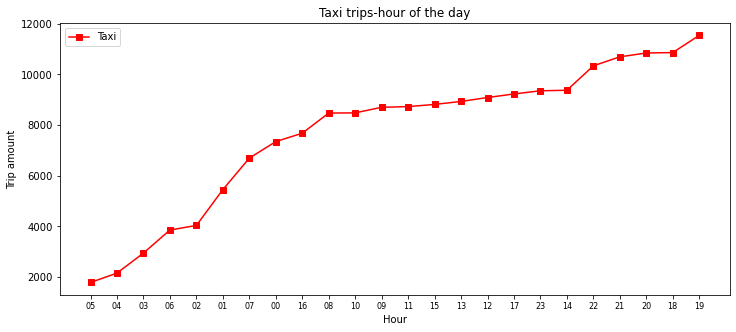

In [89]:
taxi_table1 = get_data_for_visual_1()
popular_taxi_hour(taxi_table1)

From the above graph, 19:00 (7pm-8pm) was the most popular hour to take a yellow taxi.

## **Question 2：**

We create a line graph that showsthe average distance per month
     for both Taxi and Uber combined, including 90% confidence interval.

We also create an **animation line graph** that shows average distance per month for both Taxi and Uber combined, without 90% confidence interval.

In [90]:
def get_data_for_visual_2():
    """Obtain pickup_month and distance from Uber and Taxi with SQL
       Return two dataframe named Taxi_table2 and Uber_table2
    """

    # Query SQL database for the data needed
    Query2 = """
    SELECT strftime("%m", pickup_datetime) AS pickup_month,
    distance
    FROM taxi_trips
    """
    Query22 = """
    SELECT strftime("%m", pickup_datetime) AS pickup_month,
    distance
    FROM uber_trips
    """

    Taxi_table2 = pd.read_sql_query(Query2,engine)
    Uber_table2 = pd.read_sql_query(Query22,engine)

    return Taxi_table2,Uber_table2


In [91]:
def add_90_confidence_interval(df):
    """ Calculate mean and standard deviation for distance
        Use mean and standard deviation to calculate 90% confidence interval
        Add mean, standard deviation and 90% confidence interval to dataframe
    """
    # Calculate mean and standard deviation for distance
    mean = df.groupby('pickup_month')['distance'].mean().to_frame().rename(columns={'distance':'Mean'})
    std = df.groupby('pickup_month')['distance'].std().to_frame().rename(columns={'distance':'Std'})
    df3 = pd.concat([mean,std],axis=1)

    # Use mean and standard deviation to calculate 90% confidence interval
    confidence1 = []
    confidence2 = []
    for i in range(len(df3['Mean'])):
        cf1 = round(df3['Mean'][i]-(1.64*df3['Std'][i]),2)
        cf2 = round(df3['Mean'][i]+(1.64*df3['Std'][i]),2)
        confidence1.append(cf1)
        confidence2.append(cf2)


    df3['ci_upper'] = confidence2
    df3['ci_lower'] = confidence1

    return df3

In [92]:
def avg_distance_per_month(Taxi_table22,Uber_table22):
    """Create a line graph that shows the average distance per month
      for both Taxi and Uber combined, including 90% confidence interval
    """
    x = Uber_table22.index
    k1 = Uber_table22['Mean']
    k2 = Taxi_table22['Mean']

    plt.figure(figsize=(20,10)) 
    plt.plot(x,k1,'s-',color = 'r',label="Uber")
    plt.plot(x,k2,'o-',color = 'b',label="Taxi")
    plt.legend()

    #Add 90% confidence interval
    plt.fill_between(x, Taxi_table22['ci_upper'], Taxi_table22['ci_lower'], color='b', alpha=.1)
    plt.fill_between(x, Uber_table22['ci_upper'], Uber_table22['ci_lower'], color='r', alpha=.1)
    
    plt.xlabel("Month")
    plt.ylabel("Distance")
    plt.tick_params(axis='x', labelsize=8)
    plt.title('The average distance per month')
    plt.show()

In [93]:
def distance_animation_2():
    """Create an animation line graph that shows the average distance per month
        for both Taxi and Uber combined, without 90% confidence interval
    """
    y1 = Uber_table22['Mean']
    y2 = Taxi_table22['Mean']
    t = Uber_table22.index
    fig = plt.figure(figsize=(10,4))
    camera = Camera(fig)

    # Use for-loop to create animation
    for i in range(1,len(y1)):
        new_t = t[:i]
        z1 = y1[:i]
        z2 = y2[:i]
        plt.plot(new_t,z1,linestyle='solid',color='red')
        plt.plot(new_t,z2,linestyle='solid',color='blue')
        plt.xlabel("Month")
        plt.ylabel("Distance")
        plt.tick_params(axis='x', labelsize=8)
        plt.title('The average distance per month (R for Uber; B for Taxi)')
        fig.tight_layout()
        camera.snap()

    animation = camera.animate()

    return HTML(animation.to_html5_video())
  

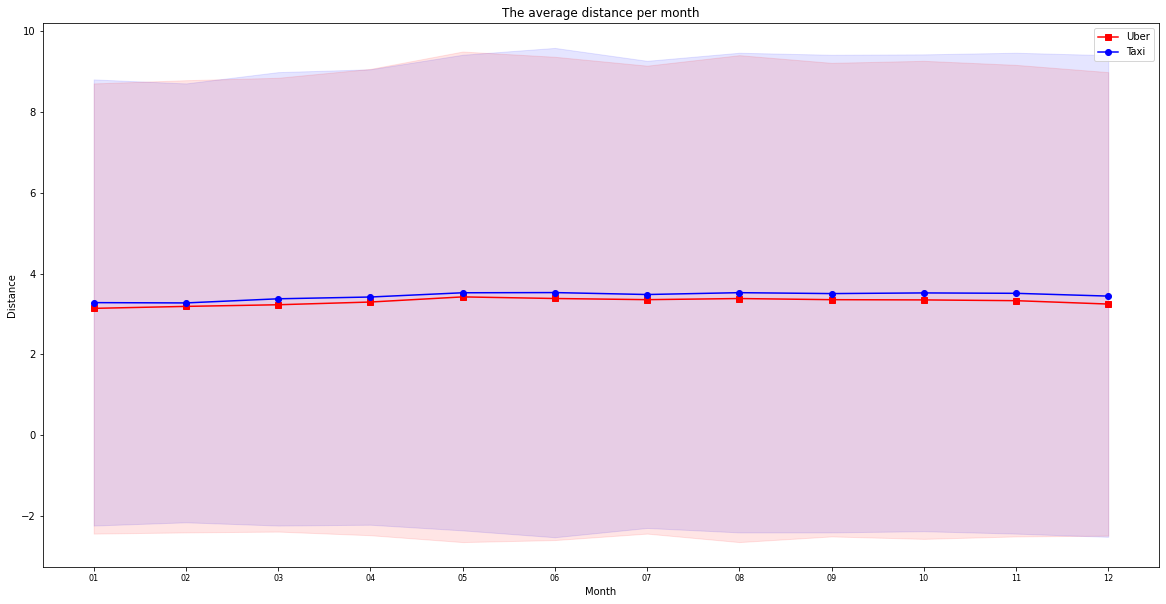

In [94]:
Taxi_table2, Uber_table2 = get_data_for_visual_2()
Taxi_table22 = add_90_confidence_interval(Taxi_table2)
Uber_table22 = add_90_confidence_interval(Uber_table2)
avg_distance_per_month(Taxi_table22,Uber_table22)

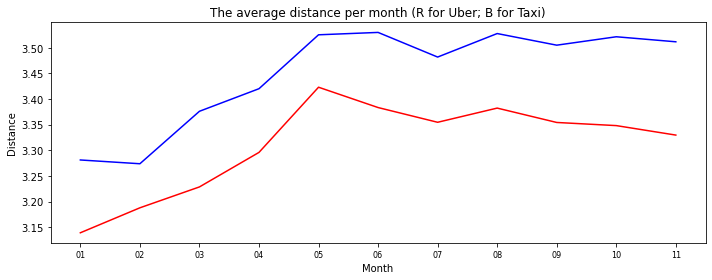

In [97]:
distance_animation_2()

## **Question 3:**

We create a bar graph that compares what day of the week was most popular for drop offs for each of the 3 airports( LGA, JFK, EWR).

Firstly, we set there lat/long coordinates boxes for those 3 airports.

Secondly, we combine date and dropoff location for taxi and those for uber with SQL.

Finally, we count dropoff numbers for each airport each day
        and create combined bar graph.


In [98]:
def get_data_for_visual_3():
    """Set the lat/lon boxes for 3 airports
       Combine date and dropoff location for taxi and those for uber with SQL
       Return a single dataframe
    """

    # Set the lat/lon boxes for 3 airports
    LGA_location = [-73.886772,40.769395,-73.858877,40.782313,'LGA']
    JFK_location = [-73.798347,40.639498,-73.770452,40.652441,'JFK']
    EWR_location = [-74.189625,40.685134,-74.161730,40.698069,'EWR']

    # Combine date and dropoff location for taxi and those for uber
    # Because Uber has no dropoff date, we use pickup_date to stand for dropoff_date for both Taxi and Uber for uniformity
    # During this process, dropoff locations for 3 airports are separated
    taxi_table = []
    for i in [LGA_location,JFK_location,EWR_location]:
        Query3 = f"""
        SELECT strftime('%w', pickup_datetime) AS {i[4]}_week FROM taxi_trips
        WHERE dropoff_longitude BETWEEN {i[0]} AND {i[2]} AND dropoff_latitude 
        BETWEEN {i[1]} AND {i[3]}
        UNION ALL
        SELECT strftime('%w', pickup_datetime) AS {i[4]}_week FROM uber_trips
        WHERE dropoff_longitude BETWEEN {i[0]} AND {i[2]} AND dropoff_latitude 
        BETWEEN {i[1]} AND {i[3]}
        """

        taxi_table3 = pd.read_sql_query(Query3,engine)
        taxi_table.append(taxi_table3)

    return taxi_table


In [99]:
def most_dropoff_airport(dataframe):
    """Count dropoff numbers for each airport each day
       Create combined bar graph for showing what day of the week was most popular for dropoffs for each airport
    """
    
    figure, axes = plt.subplots(figsize=(20, 10))
    taxi_table = dataframe

    # Count dropoff numbers for each airport each day
    LGA_week = taxi_table[0].groupby('LGA_week')['LGA_week'].count()
    JFK_week = taxi_table[1].groupby('JFK_week')['JFK_week'].count()
    EWR_week = taxi_table[2].groupby('EWR_week')['EWR_week'].count()
    index = np.arange(7)

    # Create combined bar graph
    plt.bar(index,LGA_week,width=0.3,color = 'r',label="LGA")
    plt.bar(index+0.3,JFK_week,width=0.3,color = 'g',label="JFK")
    plt.bar(index+0.6,EWR_week,width=0.3,color = 'b',label="EWR")
    plt.xlabel("Day of week")
    plt.ylabel("Dropoff_amount")
    plt.xticks(index, ('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'))
    plt.legend()
    plt.title('Most popular Dropoff-day in a week for each airport')
    plt.show() 

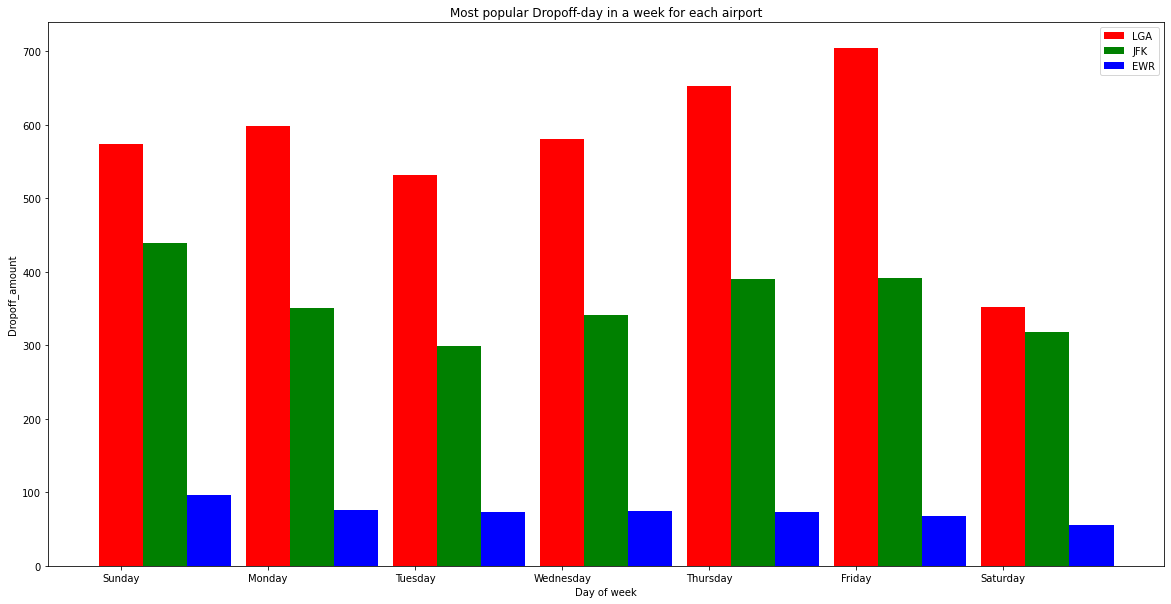

In [100]:
taxi_table3 = get_data_for_visual_3()
most_dropoff_airport(taxi_table3)

From the above bar,

As for LGA, Friday is the most popular dropoff day in a week;

As for JFK, Sunday is the most popular dropoff day in a week;

As for EWR, Sunday is the most popular dropoff day in a week;

## **Question 4:**

We create a heapmap of all hired trips over map with folium.

Firstly, we obtain the pickup_latitude and pickup_longitude for both Taxi and Uber combined with SQL. ( During this process, we use pickup locations to stand for hired trips.)

Secondly, we create the heatmap.

In [101]:
def get_data_for_visual_4():
    """Obtain pickup_latitude and pickup_longitude for both Taxi and Uber combined with SQL
       Return a single dataframe
    """
    Query4="""
    SELECT pickup_latitude,pickup_longitude
    FROM taxi_trips
    UNION ALL
    SELECT pickup_latitude,pickup_longitude
    FROM uber_trips
    """

    taxi_table4 = pd.read_sql_query(Query4,engine)

    return taxi_table4



In [102]:
def heat_map_trips(df):
    """Prepare lat and lon lists from df for mapping
       Create the heatmap for all hired trips
    """

    # Prepare lat and lon lists for mapping
    lat_lon = df.values.tolist()

    # Create maps
    map_obj = folium.Map(location = [39,-74], zoom_start = 10)

    HeatMap(lat_lon).add_to(map_obj)

    return map_obj

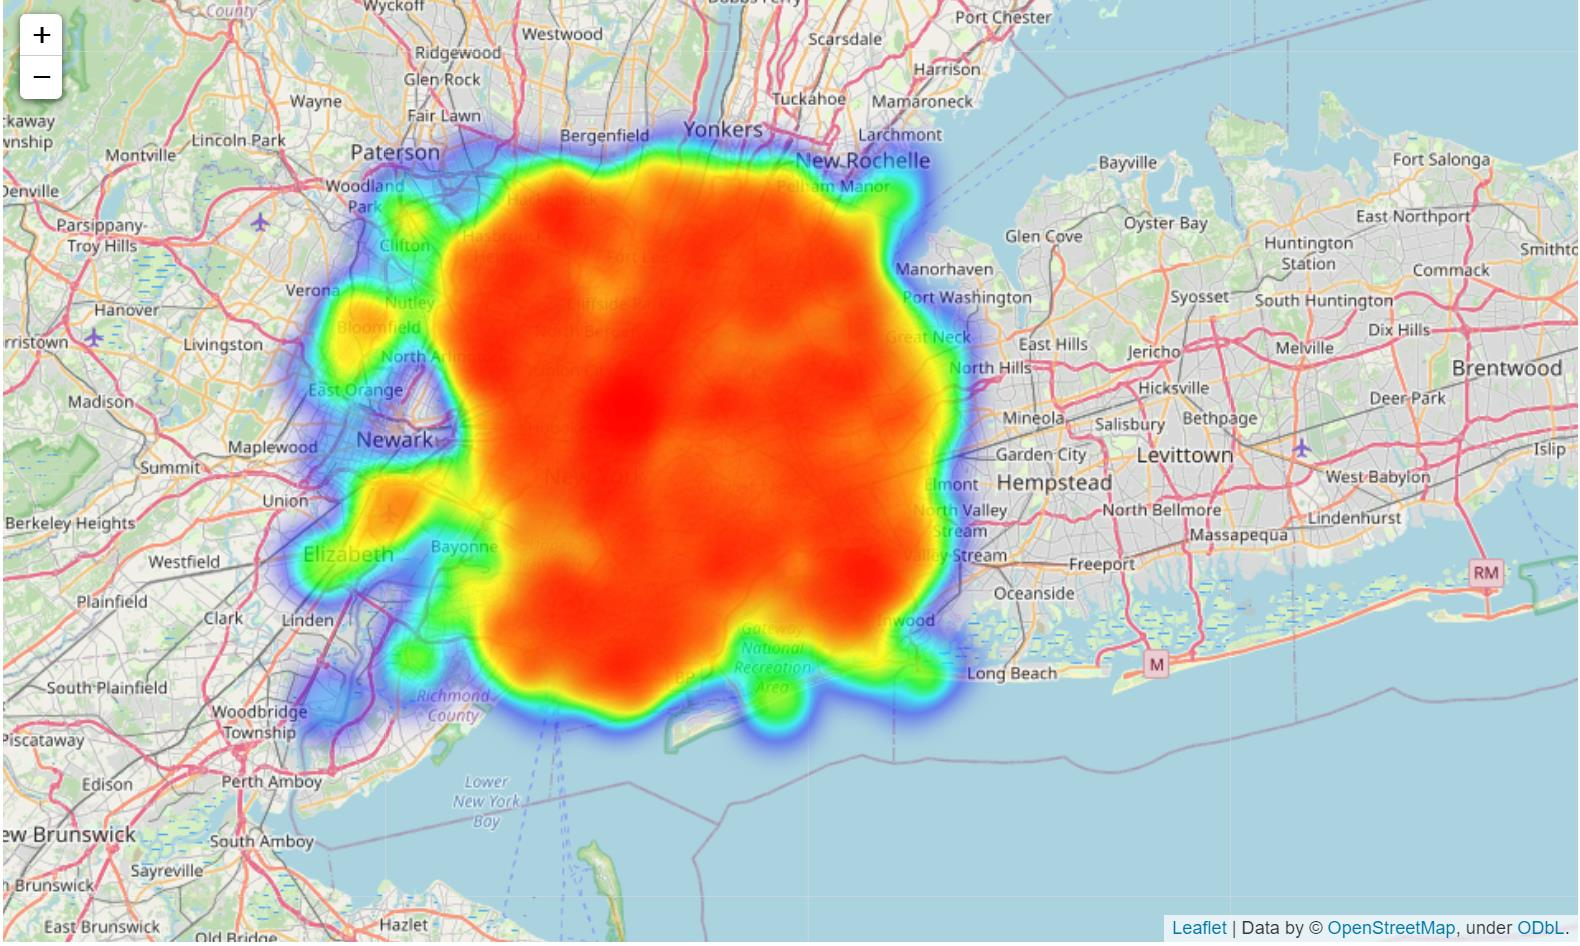

In [126]:
table4 = get_data_for_visual_4()
heat_map_trips(table4)

## **Question 5:**

We create a scatter plot to compare tip amount and distance for Yellow Taxi rides.


In [104]:
def get_data_for_visual_5(): 
    """Obatin tip_amount and distance of Taxi
       Pick up samples and remove outliers for clear relationship
      Return a single dataframe
    """
    Query5="""
    SELECT tip_amount,
    distance
    FROM taxi_trips
    """
  
    taxi_table5 = pd.read_sql_query(Query5,engine)

    # Remove outliers for clear relationship
    taxi_table5 = taxi_table5[taxi_table5['distance']<22]
    taxi_table5 = taxi_table5[taxi_table5['tip_amount']<25]
    taxi_table5 = taxi_table5[taxi_table5['tip_amount']>0]

    # Pick up samples for clear relationship
    taxi_table5 = taxi_table5.sample(n=800,replace=False,random_state=None)

    return taxi_table5
      

In [105]:
def tip_distance_taxi(df):
    """Create a scatter plt compares tip amount VS distance for Taxi"""

    plt.scatter(df['tip_amount'], df['distance'])
    plt.xlabel("Taxi_tip_amount")
    plt.ylabel("Taxi_distance")
    plt.title('Tip vs Distance For Yellow Taxi')
    plt.show()

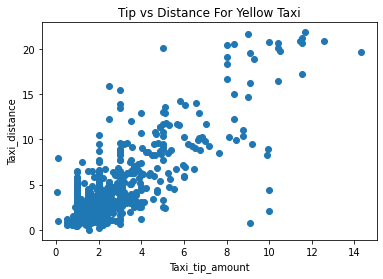

In [106]:
table5 = get_data_for_visual_5()
tip_distance_taxi(table5)

## **Question 6:**

We create another scatter plot that compares tip amount and precipitation amount for Yellow Taxi rides.

Tip amount and precipitation are matched to the hour level of day for accuracy.

In [107]:
def get_data_for_visual_6(): 
    """Obatn specific hour in the day of Taxi and hourly_weather
       Return two dataframes called taxi_table6 and weather_table6
    """
    Query61="""
    SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS hour,tip_amount
    FROM taxi_trips
    """
    Query62="""
    SELECT strftime('%Y-%m-%d %H', DATE) AS hour,HourlyPrecipitation
    FROM hourly_weather
    """

    taxi_table6 = pd.read_sql_query(Query61,engine)
    weather_table6 = pd.read_sql_query(Query62,engine)

    return taxi_table6, weather_table6


In [108]:
def tip_hourly_precipitation_taxi(taxi_table6, weather_table6):
    """Match the date-hour for Taxi and Precipitation
      Remove outliers for clear relationship
      Create Scatter plot for visulization (Tip amount and Precipitation relationship for Taxi)
    """
  
    # Match the date-hour for Taxi and Precipitation
    tip_hourly_precipitation = taxi_table6.merge(weather_table6)

    # Remove outliers for clear relationship
    tip_hourly_precipitation = tip_hourly_precipitation[tip_hourly_precipitation['tip_amount']<20]

    # Scatter plot for visulization
    plt.scatter(tip_hourly_precipitation['tip_amount'], tip_hourly_precipitation['HourlyPrecipitation'])
    plt.xlabel("Taxi_tip_amount")
    plt.ylabel("Taxi_HourlyPrecipitation")
    plt.title('Tip vs HourlyPrecipitation For Yellow Taxi')
    plt.show()

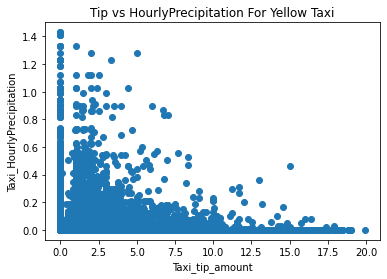

In [109]:
taxi_table6, weather_table6 = get_data_for_visual_6()
tip_hourly_precipitation_taxi(taxi_table6, weather_table6)

## **Extra Credit: Using sunset/sunrise data in relation to other tables**

Questions: How much is the percentage of uber rides in daylight and night time respectively? (from 2009-01 to 2015-06)

Answer: It tunrs out that there are 72333 uber rides in daylight, accounting for 53.8% of the total uber rides; while there are 62220 uber rides at night time, accounting for 47.2% of the total uber rides.

In [115]:
def day_night_percentage(uber_data, sun_data):
    """
    First, merge the uber dataframe and sun dataframe using the common column "DATE".
    Then, create a new column "day" to find out if the uber pickup time is within day or night, using np.where to judge.
    Last, create a pie chart the visualize the breakdown of day rides and night rides.
    """
    uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])
    uber_data['DATE'] = uber_data['pickup_datetime'].dt.date
    uber_data = uber_data[['DATE','pickup_datetime']]
    sun_data['DATE'] = sun_data['DATE'].dt.date
    df = pd.merge(uber_data, sun_data, on='DATE')
    df.dropna()
    df['day'] = np.where((df['pickup_datetime']>df['Sunrise_minute']) & (df['pickup_datetime']<df['Sunset_minute']),1,0)
    
    # plot
    import matplotlib.pyplot as plt
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'Night', 'Day'
    sizes = [df['day'].value_counts()[0], df['day'].value_counts()[1]]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('day_night_percentage for uber')
    plt.legend()
    plt.show()

    return df['day'].value_counts()

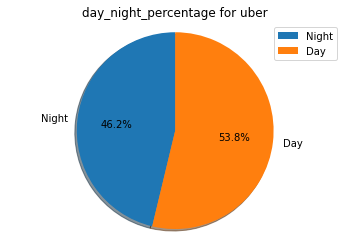

1    72333
0    62220
Name: day, dtype: int64

In [116]:
day_night_percentage(uber_data, sun_data)